# Deep Learning Project 2

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalli

In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

2025-04-16 20:39:24.194669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744835964.424441      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744835964.490425      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Tokenizer and Preprocess Data

In [3]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [4]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [5]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [6]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [7]:
!pip install peft accelerate transformers datasets

In [8]:
from peft import get_peft_model, LoraConfig, TaskType

# Configure LoRA
lora_config = LoraConfig(
    r=8,  # rank
    lora_alpha=8, # setting alpha = rank to avoid overamplifying lora
    target_modules=["query", "value"],  
    lora_dropout=0.1, # bumping up dropout
    bias="none",
    task_type=TaskType.SEQ_CLS  
)

# Wrap the model with PEFT
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [9]:
peft_model = get_peft_model(model, lora_config)
peft_model

/usr/local/lib/python3.11/dist-packages/peft/mapping.py:185: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'roberta-base' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): PeftModelForSequenceClassification(
      (base_model): LoraModel(
        (model): RobertaForSequenceClassification(
          (roberta): RobertaModel(
            (embeddings): RobertaEmbeddings(
              (word_embeddings): Embedding(50265, 768, padding_idx=1)
              (position_embeddings): Embedding(514, 768, padding_idx=1)
              (token_type_embeddings): Embedding(1, 768)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (encoder): RobertaEncoder(
              (layer): ModuleList(
                (0-11): 12 x RobertaLayer(
                  (attention): RobertaAttention(
                    (self): RobertaSdpaSelfAttention(
                      (query): lora.Linear(
                        (base_layer): Linear(in_features=768, out_features=768, bias=True)
                      

In [10]:
print("Trainable parameters:")
count = 0
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        count=count+1
        print(name)
print(count)

Trainable parameters:
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.2.attention.s

In [11]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


## Training Setup

In [12]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./roberta-lora-agnews-v2",
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=16, # reducing to 16 to improve generalization
    num_train_epochs=3,                    
    learning_rate=2e-4, # significant increase, but slightly lower than common lora LR of 2e-2                  
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

### Start Training

#### Introducing weighted crossentropy loss

Rationale behind adding Weighted Loss Trainer is that we were having uneven performance for different classes (see our metrics per business, science / tech, etc. in plots below)

In [14]:
import torch
import numpy as np
from collections import Counter

def get_class_weights(labels, num_classes):
    counts = Counter(labels)
    total = sum(counts.values())

    # Inverse frequency: total / (count * num_classes)
    weights = [total / (counts[i] * num_classes) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)

In [15]:
from transformers import Trainer

# Adding WeightedLossTrainer after observing uneven performance for different classes
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [16]:
train_labels = train_dataset["labels"]
class_weights = get_class_weights(train_labels, num_classes=4)

In [17]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights 
)

/tmp/ipykernel_19/2440602253.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.225200,0.560204,0.875000,0.876278,0.877165,0.875962
100,0.395600,0.355164,0.885938,0.893816,0.882268,0.885587
150,0.336700,0.329356,0.903125,0.906713,0.902307,0.902896
200,0.295000,0.316496,0.903125,0.904504,0.902332,0.902715
250,0.286800,0.325087,0.904687,0.909843,0.902818,0.904469
300,0.281400,0.315248,0.907813,0.907738,0.908382,0.907441
350,0.305200,0.283790,0.909375,0.910846,0.907672,0.908827
400,0.295000,0.313996,0.904687,0.903442,0.905793,0.904284
450,0.278800,0.293274,0.901563,0.904334,0.899725,0.901285
500,0.252100,0.301519,0.901563,0.902960,0.900194,0.901310


TrainOutput(global_step=11190, training_loss=0.20233608314882334, metrics={'train_runtime': 10879.0472, 'train_samples_per_second': 32.915, 'train_steps_per_second': 1.029, 'total_flos': 6.31134824174377e+16, 'train_loss': 0.20233608314882334, 'epoch': 3.0})

### Training Plots

In [19]:
logs = trainer.state.log_history

In [20]:
log_df = pd.DataFrame(logs)
log_df = log_df[log_df["step"].notnull()]  # keep rows that are tied to steps
log_df.reset_index(drop=True, inplace=True)
log_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.2252,1.694089,0.000199,0.013405,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.013405,50,0.560204,0.875000,0.876278,0.877165,0.875962,6.3019,101.556,3.174,NaN,NaN,NaN,NaN,NaN
2,0.3956,2.137249,0.000198,0.026810,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.026810,100,0.355164,0.885938,0.893816,0.882268,0.885587,6.9469,92.127,2.879,NaN,NaN,NaN,NaN,NaN
4,0.3367,1.762012,0.000197,0.040214,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
trainer.state.best_model_checkpoint

In [22]:
log_df = pd.DataFrame(trainer.state.log_history)
best_step = log_df.loc[log_df["eval_accuracy"].idxmax(), "step"]
best_metric = log_df["eval_accuracy"].max()

print(f"Best model was at step {best_step} with accuracy {best_metric:.4f}")

Best model was at step 10650 with accuracy 0.9391


In [23]:
best_checkpoint = f"./roberta-lora-agnews-v5/checkpoint-{best_step}"
if os.path.exists(best_checkpoint):
    print(f"Checkpoint exists: {best_checkpoint}")
else:
    print(f"Checkpoint not found — might need to reduce save_steps next time.")

Checkpoint not found — might need to reduce save_steps next time.


In [24]:
log_df = pd.DataFrame(trainer.state.log_history)

# ✅ Filter rows that have actual eval_accuracy (i.e., only evaluation steps)
eval_df = log_df[log_df["eval_accuracy"].notnull() & log_df["step"].notnull()]
eval_df = eval_df.drop_duplicates(subset="step", keep="last")

# Check if more than one entry exists
if len(eval_df) < 2:
    print("Only one evaluation step was logged. Try reducing `eval_steps` or training longer.")
else:
    top_10 = eval_df.sort_values("eval_accuracy", ascending=False).head(10)
    print("🔝 Top 10 Evaluation Steps by Accuracy:")
    for i, row in top_10.iterrows():
        print(f"🔹 Step {int(row['step'])} → Accuracy: {row['eval_accuracy']:.4f}")


🔝 Top 10 Evaluation Steps by Accuracy:
🔹 Step 10650 → Accuracy: 0.9391
🔹 Step 9100 → Accuracy: 0.9375
🔹 Step 9850 → Accuracy: 0.9375
🔹 Step 5650 → Accuracy: 0.9375
🔹 Step 8000 → Accuracy: 0.9375
🔹 Step 7550 → Accuracy: 0.9375
🔹 Step 8200 → Accuracy: 0.9375
🔹 Step 6250 → Accuracy: 0.9375
🔹 Step 4800 → Accuracy: 0.9375
🔹 Step 9800 → Accuracy: 0.9375


In [25]:
log_df.head(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.2252,1.694089,0.000199,0.013405,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.013405,50,0.560204,0.875000,0.876278,0.877165,0.875962,6.3019,101.556,3.174,NaN,NaN,NaN,NaN,NaN
2,0.3956,2.137249,0.000198,0.026810,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.026810,100,0.355164,0.885938,0.893816,0.882268,0.885587,6.9469,92.127,2.879,NaN,NaN,NaN,NaN,NaN
4,0.3367,1.762012,0.000197,0.040214,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.040214,150,0.329356,0.903125,0.906713,0.902307,0.902896,6.6750,95.879,2.996,NaN,NaN,NaN,NaN,NaN
6,0.2950,1.973600,0.000196,0.053619,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.053619,200,0.316496,0.903125,0.904504,0.902332,0.902715,6.9904,91.554,2.861,NaN,NaN,NaN,NaN,NaN
8,0.2868,1.981034,0.000196,0.067024,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.067024,250,0.325087,0.904687,0.909843,0.902818,0.904469,7.0094,91.306,2.853,NaN,NaN,NaN,NaN,NaN


In [26]:
# Step 1: Keep only rows where eval_accuracy is not null
eval_df = log_df[log_df["eval_accuracy"].notnull()].copy()

# Step 2: Drop duplicates (some steps might be logged more than once)
eval_df = eval_df.drop_duplicates(subset="step", keep="last")

# Step 3: Sort and take top 10
top_10 = eval_df.sort_values("eval_accuracy", ascending=False).head(100)

# Display
print("Top 10 Evaluation Steps by Accuracy:")
for i, row in top_10.iterrows():
    print(f"🔹 Step {int(row['step'])} → Accuracy: {row['eval_accuracy']:.4f}")

top_10.to_csv("top10_eval_accuracy.csv", index=False)

Top 10 Evaluation Steps by Accuracy:
🔹 Step 10650 → Accuracy: 0.9391
🔹 Step 9100 → Accuracy: 0.9375
🔹 Step 9850 → Accuracy: 0.9375
🔹 Step 5650 → Accuracy: 0.9375
🔹 Step 8000 → Accuracy: 0.9375
🔹 Step 7550 → Accuracy: 0.9375
🔹 Step 8200 → Accuracy: 0.9375
🔹 Step 6250 → Accuracy: 0.9375
🔹 Step 4800 → Accuracy: 0.9375
🔹 Step 9800 → Accuracy: 0.9375
🔹 Step 6700 → Accuracy: 0.9375
🔹 Step 7050 → Accuracy: 0.9359
🔹 Step 11150 → Accuracy: 0.9359
🔹 Step 10750 → Accuracy: 0.9359
🔹 Step 5450 → Accuracy: 0.9359
🔹 Step 10700 → Accuracy: 0.9359
🔹 Step 10850 → Accuracy: 0.9359
🔹 Step 7950 → Accuracy: 0.9359
🔹 Step 8600 → Accuracy: 0.9359
🔹 Step 7200 → Accuracy: 0.9359
🔹 Step 9200 → Accuracy: 0.9359
🔹 Step 4350 → Accuracy: 0.9359
🔹 Step 6650 → Accuracy: 0.9359
🔹 Step 9550 → Accuracy: 0.9359
🔹 Step 5250 → Accuracy: 0.9359
🔹 Step 10600 → Accuracy: 0.9344
🔹 Step 10950 → Accuracy: 0.9344
🔹 Step 7300 → Accuracy: 0.9344
🔹 Step 7350 → Accuracy: 0.9344
🔹 Step 4750 → Accuracy: 0.9344
🔹 Step 6950 → Accuracy: 0.

In [27]:
from tqdm import tqdm
from transformers import Trainer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig

checkpoints_dir = "./roberta-lora-agnews-v2"

def load_peft_checkpoint(path, num_labels=4):
    config = PeftConfig.from_pretrained(path)
    base_model = AutoModelForSequenceClassification.from_pretrained(
        config.base_model_name_or_path, num_labels=num_labels
    )
    model = PeftModel.from_pretrained(base_model, path)
    return model

checkpoint_paths = sorted([
    os.path.join(checkpoints_dir, d)
    for d in os.listdir(checkpoints_dir)
    if d.startswith("checkpoint-")
])

results = []

# Evaluate all checkpoints
for path in tqdm(checkpoint_paths):
    try:
        model = load_peft_checkpoint(path, num_labels=4)
        model.to("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()

        # Reuse Trainer for evaluation
        trainer = Trainer(
            model=model,
            args=training_args,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics
        )

        eval_result = trainer.evaluate()
        results.append({
            "checkpoint": path,
            **eval_result
        })

    except Exception as e:
        print(f"Failed to evaluate {path}: {e}")

# Save results to CSV and print best checkpoint
df = pd.DataFrame(results)
df_sorted = df.sort_values("eval_accuracy", ascending=False)

print("Best checkpoint based on eval_accuracy:")
print(df_sorted.head(1))

df_sorted.to_csv("checkpoint_eval_summary.csv", index=False)

  0%|          | 0/23 [00:00<?, ?it/s]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all inp

  4%|▍         | 1/23 [00:07<02:49,  7.72s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

  9%|▊         | 2/23 [00:15<02:39,  7.61s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

 13%|█▎        | 3/23 [00:22<02:31,  7.58s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

 17%|█▋        | 4/23 [00:30<02:23,  7.57s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

 22%|██▏       | 5/23 [00:38<02:18,  7.72s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

 26%|██▌       | 6/23 [00:45<02:10,  7.66s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

 30%|███       | 7/23 [00:53<02:01,  7.60s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

 35%|███▍      | 8/23 [01:10<02:40, 10.72s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

 39%|███▉      | 9/23 [01:18<02:16,  9.75s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but

 43%|████▎     | 10/23 [01:26<01:58,  9.13s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 48%|████▊     | 11/23 [01:34<01:46,  8.87s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 52%|█████▏    | 12/23 [01:42<01:33,  8.53s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 57%|█████▋    | 13/23 [01:49<01:22,  8.24s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 61%|██████    | 14/23 [01:57<01:12,  8.00s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 65%|██████▌   | 15/23 [02:04<01:02,  7.82s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 70%|██████▉   | 16/23 [02:11<00:53,  7.70s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 74%|███████▍  | 17/23 [02:19<00:46,  7.73s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 78%|███████▊  | 18/23 [02:27<00:38,  7.64s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 83%|████████▎ | 19/23 [02:34<00:30,  7.60s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 87%|████████▋ | 20/23 [02:42<00:22,  7.62s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 91%|█████████▏| 21/23 [02:49<00:15,  7.60s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 96%|█████████▌| 22/23 [02:57<00:07,  7.70s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/195176718.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

100%|██████████| 23/23 [03:05<00:00,  8.06s/it]

Best checkpoint based on eval_accuracy:
                                  checkpoint  eval_loss  eval_accuracy  \
19  ./roberta-lora-agnews-v2/checkpoint-8000   0.197147         0.9375   

    eval_precision  eval_recall  eval_f1  eval_runtime  \
19        0.940835     0.936927  0.93856        7.1707   

    eval_samples_per_second  eval_steps_per_second  
19                   89.252                  2.789  


In [28]:
best_model = load_peft_checkpoint("./roberta-lora-agnews-v2/checkpoint-7000")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipykernel_19/2262595013.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_df["train_loss"] = log_df["loss"].fillna(method="ffill")


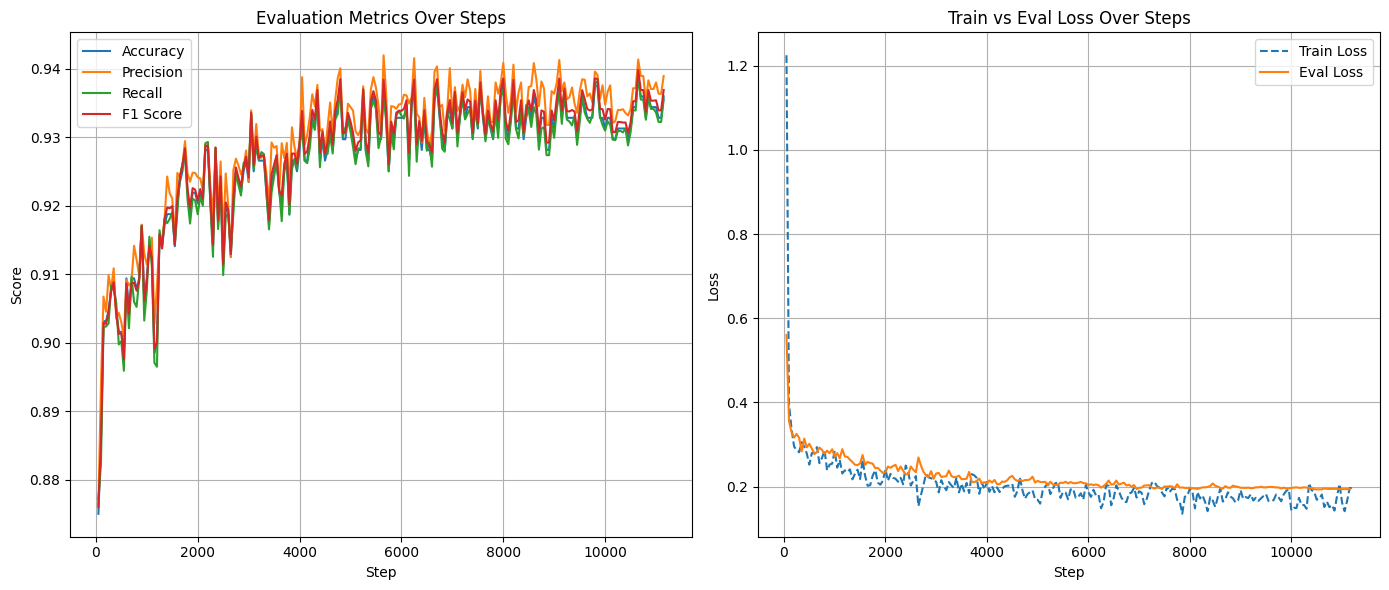

In [29]:
import matplotlib.pyplot as plt

# Clean the DataFrame: remove rows without step
log_df = log_df[log_df["step"].notnull()]
log_df = log_df.reset_index(drop=True)

# Fill train loss forward (every other row has it missing)
log_df["train_loss"] = log_df["loss"].fillna(method="ffill")

# Filter to rows with evaluation metrics
eval_df = log_df[log_df["eval_accuracy"].notnull()]

# Plotting
def plot_metrics_from_csv(log_df, eval_df):
    plt.figure(figsize=(14, 6))

    # Evaluation Metrics
    plt.subplot(1, 2, 1)
    plt.plot(eval_df["step"], eval_df["eval_accuracy"], label="Accuracy")
    plt.plot(eval_df["step"], eval_df["eval_precision"], label="Precision")
    plt.plot(eval_df["step"], eval_df["eval_recall"], label="Recall")
    plt.plot(eval_df["step"], eval_df["eval_f1"], label="F1 Score")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics Over Steps")
    plt.legend()
    plt.grid(True)

    # Training vs Evaluation Loss
    plt.subplot(1, 2, 2)
    plt.plot(log_df["step"], log_df["train_loss"], label="Train Loss", linestyle="--")
    plt.plot(eval_df["step"], eval_df["eval_loss"], label="Eval Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Train vs Eval Loss Over Steps")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics_from_csv(log_df, eval_df)

In [30]:
log_df.to_csv("training_metrics V5.1.csv", index=False)
print("✅ Training metrics saved to training_metrics.csv")

✅ Training metrics saved to training_metrics.csv


In [31]:
## Plan to later compare models

log_df = pd.read_csv("training_metrics V5.1.csv")

## Evaluate Finetuned Model

### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [32]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [33]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlingand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [34]:
!pip install evaluate

In [35]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import torch

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Returns:
        If labelled is True:
            - metrics (dict)
            - predictions (tensor)
            - true labels (tensor)
        Else:
            - predictions only
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    all_labels = []

    if labelled:
        accuracy_metric = evaluate.load("accuracy")
        precision_metric = evaluate.load("precision")
        recall_metric = evaluate.load("recall")
        f1_metric = evaluate.load("f1")

    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)

        all_predictions.append(predictions.cpu())

        if labelled:
            labels = batch["labels"].cpu()
            all_labels.append(labels)

            accuracy_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            precision_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            recall_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            f1_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        all_labels = torch.cat(all_labels, dim=0)

        # Introducing other metrics for better assessment and improvmeent of model
        eval_metric = {
            "accuracy": accuracy_metric.compute(),
            "precision": precision_metric.compute(average="macro"),
            "recall": recall_metric.compute(average="macro"),
            "f1": f1_metric.compute(average="macro"),
        }

        print("Evaluation Metrics:", eval_metric)
        return eval_metric, all_predictions, all_labels
    else:
        return all_predictions

In [36]:
metrics, predictions, labels = evaluate_model(
    model,
    eval_dataset,
    labelled=True,
    data_collator=data_collator
)

100%|██████████| 80/80 [00:12<00:00,  6.66it/s]

Evaluation Metrics: {'accuracy': {'accuracy': 0.9328125}, 'precision': {'precision': 0.9366236424579355}, 'recall': {'recall': 0.9321286366000421}, 'f1': {'f1': 0.9340222076062191}}


In [37]:
from sklearn.metrics import classification_report

class_names = dataset.features["label"].names

print("\nPer-Class Metrics:\n")
print(classification_report(labels.numpy(), predictions.numpy(), target_names=class_names))


Per-Class Metrics:

              precision    recall  f1-score   support

       World       0.96      0.91      0.93       145
      Sports       0.98      0.97      0.97       158
    Business       0.93      0.92      0.92       153
    Sci/Tech       0.88      0.93      0.91       184

    accuracy                           0.93       640
   macro avg       0.94      0.93      0.93       640
weighted avg       0.93      0.93      0.93       640



In [38]:
import matplotlib.pyplot as plt

def plot_per_class_f1(preds, labels, class_names):
    report = classification_report(
        labels.numpy(),
        preds.numpy(),
        target_names=class_names,
        output_dict=True
    )
    f1_scores = {cls: report[cls]["f1-score"] for cls in class_names}

    plt.figure(figsize=(10, 5))
    plt.bar(f1_scores.keys(), f1_scores.values())
    plt.ylim(0, 1)
    plt.ylabel("F1 Score")
    plt.title("Per-Class F1 Scores")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

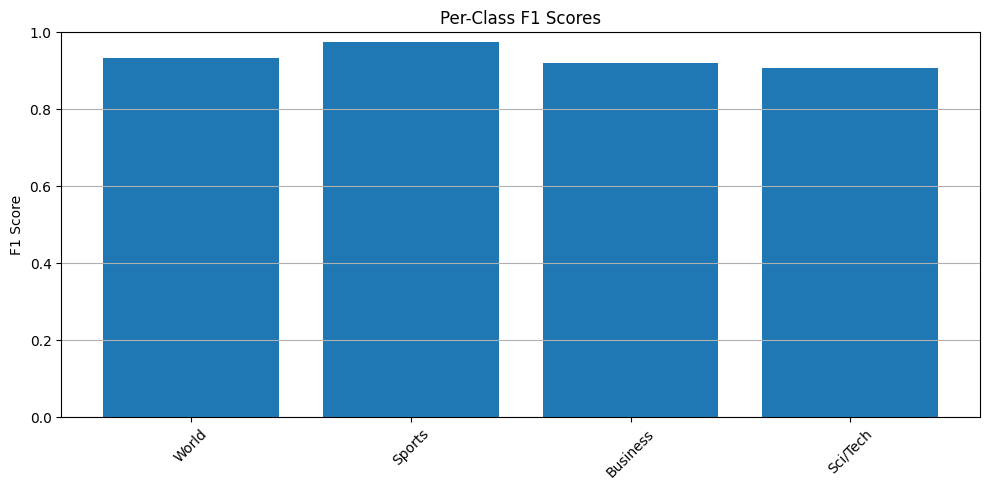

In [39]:
plot_per_class_f1(predictions, labels, class_names)

In [40]:
!pip install scikit-learn matplotlib seaborn

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, labels, class_names):
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)

    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names, rotation=0)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

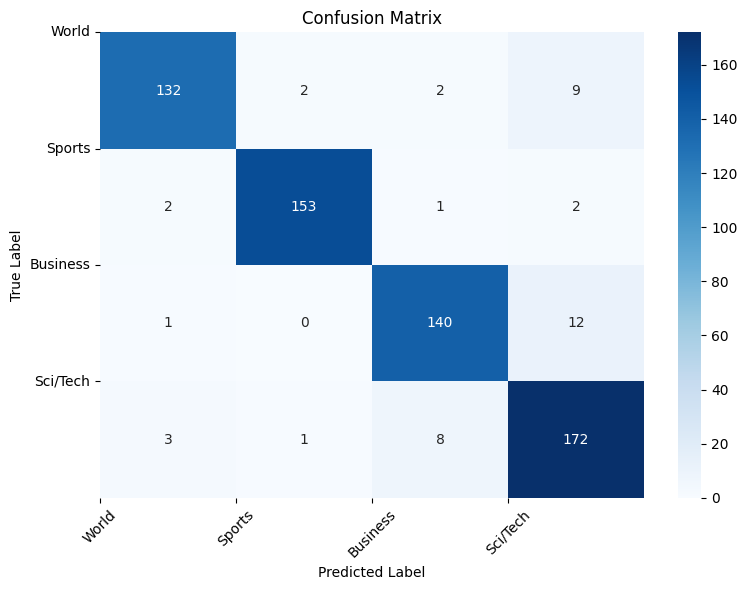

In [42]:
plot_confusion_matrix(predictions.numpy(), labels.numpy(), class_names)

In [43]:
import pandas as pd
df = pd.DataFrame({"predictions": predictions, "labels": labels})
df.to_csv("confusion_data.csv", index=False)

### Run Inference on unlabelled dataset

In [44]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [45]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})

df_output.to_csv('/kaggle/working/submission.csv', index=False)
print("Inference complete. Predictions saved to submission.csv")

100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s]

Inference complete. Predictions saved to submission.csv
